In [1]:
# ANDREA RUSSO - JUNE 2021 COHORT
# 07/2021 EXAM

In [2]:
# QUESTION 1

In [3]:
# Import relevant libraries
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from scipy.stats import norm
from tabulate import tabulate

import matplotlib
import matplotlib.pyplot as plt

# Plot settings
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [22.0, 8.0]
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['lines.linewidth']=1

In [4]:
# Load S&P500 file

df=pd.read_csv('Data_SP500.csv',index_col=0,parse_dates=True,infer_datetime_format=True)
df.head(3)

,SP500
Date,
2013-01-22,1492.560059
2013-01-23,1494.810059
2013-01-24,1494.819946


In [5]:
# Compute percentile returns

df['Log Ret']=(np.log(df['SP500'])-np.log(df['SP500'].shift(1))).fillna(0)

In [6]:
# Set up zeros dataframe columns

# For both rolling windows
df['10d log_rets']= pd.Series([0 for x in range(len(df.index))], index=df.index)

# For 21 days rolling window
df['21d std']= pd.Series([np.nan for x in range(len(df.index))], index=df.index)
df['21d VaR_10d_99']=pd.Series([np.nan for x in range(len(df.index))], index=df.index)
df['Breach_21']=pd.Series([0 for x in range(len(df.index))], index=df.index)
df['Cons_brch_21']=pd.Series([0 for x in range(len(df.index))], index=df.index)

# For 42 days rolling window
df['42d std']= pd.Series([np.nan for x in range(len(df.index))], index=df.index)
df['42d VaR_10d_99']=pd.Series([np.nan for x in range(len(df.index))], index=df.index)
df['Breach_42']=pd.Series([0 for x in range(len(df.index))], index=df.index)
df['Cons_brch_42']=pd.Series([0 for x in range(len(df.index))], index=df.index)

In [7]:
# We set the mean to 0 for the 10 days VaR as the time interval is too small for it to matter
mean10d=0

In [8]:
# Compute future realised returns

# Future returns are not available for the last 10 dates.
# Hence, VaR cannot be backtested fpr those dates as there are no future returns to compare it with

for k in range(21,(len(df.index)-10)):
    df['10d log_rets'].iloc[k]=np.log(df['SP500'].iloc[k+10])-np.log(df['SP500'].iloc[k])

In [9]:
# Compute rolling stdev and calculate 10 days VaR at 99% confidence 

# 21 days stdev
for k in range(len(df.index)-21):
    df['21d std'].iloc[k+21]=df['Log Ret'].iloc[k:(k+21)].std()
    df['21d VaR_10d_99'].iloc[k+21]=norm.ppf(1-0.99, loc=mean10d, scale=df['21d std'].iloc[k+21])*np.sqrt(10)

# 42 days stdev
for k in range(len(df.index)-42):
    df['42d std'].iloc[k+42]=df['Log Ret'].iloc[k:(k+42)].std()
    df['42d VaR_10d_99'].iloc[k+42]=norm.ppf(1-0.99, loc=mean10d, scale=df['42d std'].iloc[k+42])*np.sqrt(10)

In [10]:
# Identify breaches and count consecutive breaches hat have happened

# For 21 days rolling window
for k in range(21,(len(df.index)-10)):
    df['Cons_brch_21'].iloc[k]=df['Cons_brch_21'].iloc[k-1]
    if df['10d log_rets'].iloc[k] < df['21d VaR_10d_99'].iloc[k]:
        df['Breach_21'].iloc[k]=1
    if df['Breach_21'].iloc[k-1]==1 and df['Breach_21'].iloc[k]==1:
        df['Cons_brch_21'].iloc[k]=df['Cons_brch_21'].iloc[k-1]+1
        
# For 42 days rolling window
for k in range(42,(len(df.index)-10)):
    df['Cons_brch_42'].iloc[k]=df['Cons_brch_42'].iloc[k-1]
    if df['10d log_rets'].iloc[k] < df['42d VaR_10d_99'].iloc[k]:
        df['Breach_42'].iloc[k]=1
    if df['Breach_42'].iloc[k-1]==1 and df['Breach_21'].iloc[k]==1:
        df['Cons_brch_42'].iloc[k]=df['Cons_brch_42'].iloc[k-1]+1

In [11]:
# Compute number of observations, number of breaches, percentage of VaR breaches and breach conditional probability 

# For 21 days rolling window
Nobs21=len(df.index)-(21+10)
Nbreach21=df['Breach_21'].sum()
Breach_pct21=np.around(Nbreach21/Nobs21*100,2)
Nbrch_cons21=df['Cons_brch_21'].max()
Brch_cond21=np.around(Nbrch_cons21/Nbreach21*100,2)

# For 42 days rolling window
Nobs42=len(df.index)-(42+10)
Nbreach42=df['Breach_42'].sum()
Breach_pct42=np.around(Nbreach42/Nobs42*100,2)
Nbrch_cons42=df['Cons_brch_42'].max()
Brch_cond42=np.around(Nbrch_cons42/Nbreach42*100,2)

In [12]:
# Tabulate results
# Output resuts in table format
table=[['Num of obs',Nobs21,Nobs42],['Num of breaches',Nbreach21,Nbreach42],['VaR breaches (%)',Breach_pct21,Breach_pct42],['Num of consecutive breaches',Nbrch_cons21,Nbrch_cons42],['Cond breach prob (%)',Brch_cond21,Brch_cond42]]
header = ['VaR stats','21 days rolling window', '42 days rolling window']
print(tabulate(table,headers=header))

VaR stats                      21 days rolling window    42 days rolling window
---------------------------  ------------------------  ------------------------
Num of obs                                    1219                      1198
Num of breaches                                 25                        19
VaR breaches (%)                                 2.05                      1.59
Num of consecutive breaches                     14                         9
Cond breach prob (%)                            56                        47.37


In [13]:
# Set dataframe with individual breach points
breach21=pd.DataFrame(df[df['Breach_21']==1]['10d log_rets'])
breach42=pd.DataFrame(df[df['Breach_42']==1]['10d log_rets'])

# Set dataframe where both VaR have been breached
sameval=pd.DataFrame(df[df['Breach_21']==df['Breach_42']])
doublebreach=pd.DataFrame(sameval[sameval['Breach_21']==1]['10d log_rets'])

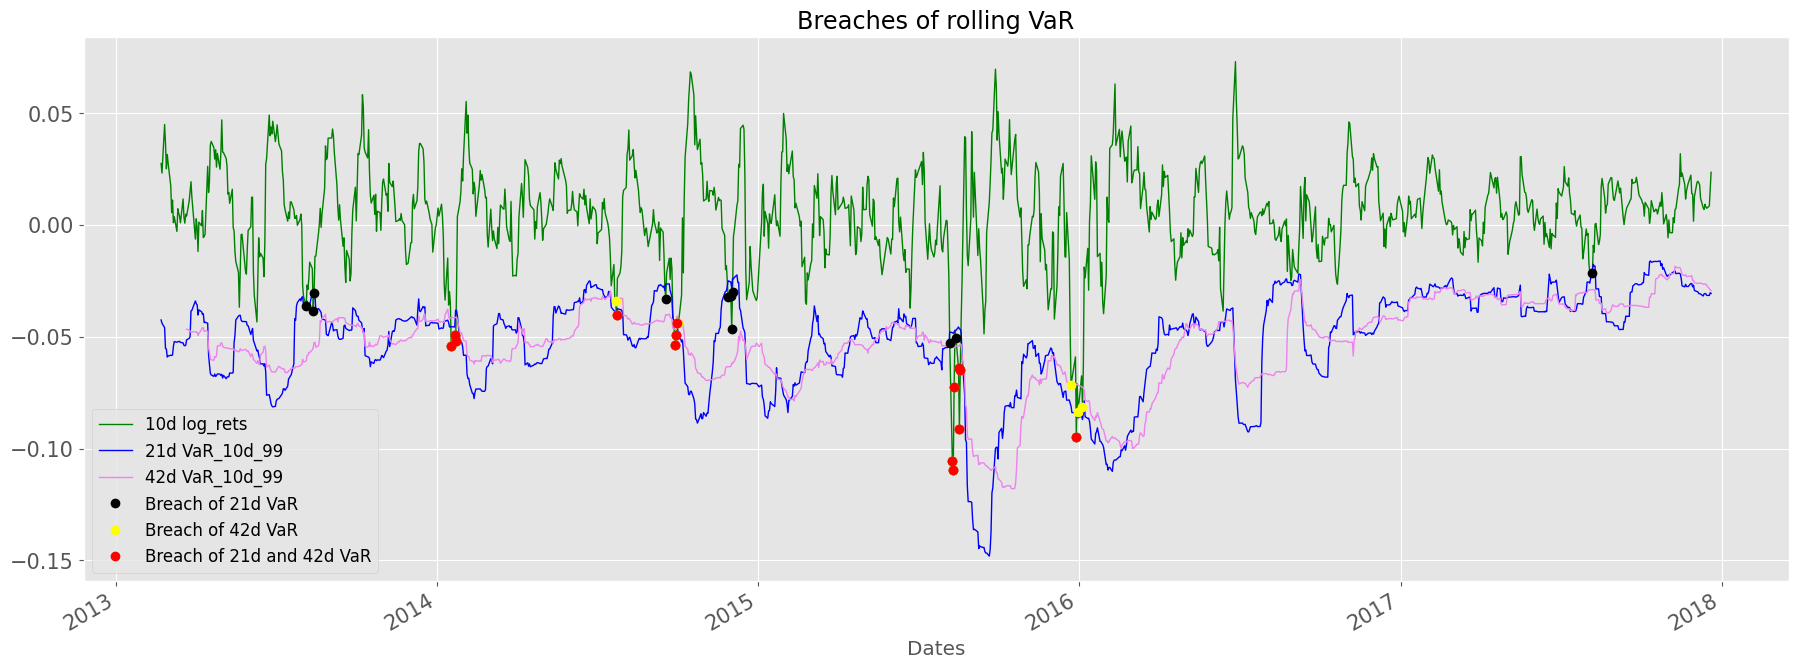

In [17]:
# Plot dataframes and export plot


fig=df[['10d log_rets','21d VaR_10d_99','42d VaR_10d_99']][21:1240].plot(xlabel='Dates',title='Breaches of rolling VaR',fontsize=15,color=['green','blue','violet'])
plt.plot(breach21,'o',color='black',label='Breach of 21d VaR')
plt.plot(breach42,'o',color='yellow',label='Breach of 42d VaR')
plt.plot(doublebreach,'o',color='red',label='Breach of 21d and 42d VaR')
plt.legend(loc='best')
plt.show()

fig.figure.savefig("Question_1_plot.pdf", bbox_inches='tight')